# Gaussian linear regression - standalone


In [20]:
%pip install --upgrade pip
# freeze blackjax to the last commit as of the time of writing
%pip install -q git+https://github.com/blackjax-devs/blackjax.git@7100bca3ea39def4bbeaa179a015f67abfa0b1f0
%pip install --upgrade -q git+https://github.com/kuperov/welford.git

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [21]:
# %pip freeze

In [22]:
from jax.config import config
config.update("jax_enable_x64", True)
import jax
from jax import numpy as jnp
for i, dev in enumerate(jax.devices()):
  print(f"Device {i}. {dev}")

Device 0. TFRT_CPU_0


In [23]:
import blackjax as bj
assert bj.__version__ == "0.9.7.dev153+g7100bca"
from blackjax.mcmc.hmc import HMCState

In [24]:
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from tensorflow_probability.substrates import jax as tfp
from typing import NamedTuple, Dict, Callable, Tuple
from welford import *
import matplotlib.pyplot as plt
tfd = tfp.distributions
tfb = tfp.bijectors

In [25]:
class Theta(NamedTuple):
    beta: jax.Array
    sigsq: jax.Array

sigsq_t = tfb.Exp()

def generate(key: jax.random.KeyArray, N: int, beta0: jax.Array, sigsq0: jax.Array):
    y_key, X_key = jax.random.split(key)
    p = len(beta0)
    X = tfd.Normal(loc=0, scale=1).sample(sample_shape=(N, p), seed=X_key)
    y = X@beta0 + jnp.sqrt(sigsq0)*tfd.Normal(loc=0, scale=1.).sample(sample_shape=(N,), seed=y_key)
    return y, X

def to_constrained(theta: Theta) -> Theta:
    return Theta(beta=theta.beta, sigsq=sigsq_t.forward(theta.sigsq))

def get_model(y, X, K):
    N, p = X.shape
    # use exp to transform sigsq to unconstrained space

    beta_prior = tfd.MultivariateNormalDiag(loc=jnp.zeros(p), scale_diag=10*jnp.ones(p))
    sigsq_prior = tfd.InverseGamma(2.0, 2.0)

    def logjoint_density(theta: Theta, fold_id: int, model_id: int, prior_only: bool = False) -> jax.Array:
        """Log joint density for a given fold.
        
        Args:
            theta: model parameters
            fold_id: zero-based fold id for training set, -1 for entire dataset
            model_id: 0 for model A, 1 for model B
            prior_only: if True, only return prior density
        
        Returns:
            log density
        """
        # transform to constrained space
        sigsq = sigsq_t.forward(theta.sigsq)
        sigsq_ldj = sigsq_t.forward_log_det_jacobian(theta.sigsq)
        # prior is same for all folds
        lp = beta_prior.log_prob(theta.beta) + sigsq_prior.log_prob(sigsq)
        ll_mask = ((jnp.arange(N) % K) != fold_id).astype(jnp.float32)  # select fold
        # model A has all the predictors, model B is missing the last predictor
        beta_mask = jnp.where(model_id == 0, jnp.ones(p), jnp.concatenate([jnp.ones(p-1), jnp.zeros(1)]))
        eps = (y - X @ (theta.beta * beta_mask))
        ll_contribs = tfd.Normal(loc=0., scale=jnp.sqrt(sigsq)).log_prob(eps)
        ll = (ll_mask * ll_contribs).sum() * (not prior_only)
        return lp + ll + sigsq_ldj

    # predictive density log p(y_train|theta)
    def log_pred(theta: Theta, fold_id: int, model_id: int):
        # transform to constrained space
        sigsq = sigsq_t.forward(theta.sigsq)
        pred_mask = ((jnp.arange(N) % K) == fold_id).astype(jnp.float32)
        beta_mask = jnp.where(model_id == 0, jnp.ones(p), jnp.concatenate([jnp.ones(p-1), jnp.zeros(1)]))
        ll_contribs = tfd.Normal(loc=X @ (theta.beta * beta_mask), scale=jnp.sqrt(sigsq)).log_prob(y)
        return (pred_mask * ll_contribs).sum()

    # random initialization in the constrained parameter space
    def make_initial_pos(key: jax.random.KeyArray):
        k1, k2 = jax.random.split(key)
        theta = Theta(
            beta=jax.random.normal(key=k1, shape=(p,)),
            sigsq=jax.random.normal(key=k2))
        return theta

    return logjoint_density, log_pred, make_initial_pos


In [26]:
num_folds=5
num_models=2
num_chains=4
batch_size=150
num_integration_steps=10

total_batches=200
warmup_iter=1_000

random_seed=123
inference_key, data_key=jax.random.split(jax.random.PRNGKey(random_seed))

y, X = generate(key=data_key,
                N = 100,
                beta0 = jnp.array([1.0, 1.0, 1.0, 0.4]),
                sigsq0 = jnp.array(2.0))
logjoint_density, log_pred, make_initial_pos = get_model(y, X, num_folds)

In [27]:
@jax.jit
def find_initial_params(rng_key, fold_id, model_id):
    """Use adam to approximately maximize the log joint density."""""
    import optax
    params = make_initial_pos(rng_key)
    optimizer = optax.adam(learning_rate=1.0)
    f = lambda x: -logjoint_density(x, fold_id, model_id, prior_only=False)
    state = optimizer.init(params)
    def loop_body(i, carry):
        params, state = carry
        _, grads = jax.value_and_grad(f)(params)
        updates, new_state = optimizer.update(grads, state)
        new_params = optax.apply_updates(params, updates)
        return new_params, new_state
    params, _ = jax.lax.fori_loop(0, 100, loop_body, (params, state))
    return params


Window adaptation to find a good step size, inverse mass matrix for full-data model

In [28]:
class ExtendedState(NamedTuple):
    """MCMC state--extends regular HMC state variable--also includes batch welford accumulators"""
    state: HMCState  # current HMC state
    rng_key: jax.random.KeyArray  # current random seed
    pred_ws: LogWelfordState  # accumulator for log predictive
    pred_bws: BatchLogWelfordState  # batch accumulator for log predictive, size b
    pred_bws3: BatchLogWelfordState  # batch accumulator for log predictive, size floor(b/3)
    divergences: jax.Array  # divergence counts (int array)

def init_ext_state(state, rng_key):
    """Create initial state"""
    return ExtendedState(
        state=state,
        rng_key=rng_key,
        pred_ws=log_welford_init(()),
        pred_bws=batch_log_welford_init((), batch_size),
        pred_bws3=batch_log_welford_init((), batch_size // 3),
        divergences=jnp.array(0, dtype=jnp.int32),
    )

def reset_ext_state(state):
    """Reset averages after warmup"""
    return ExtendedState(
        state=state.state,
        rng_key=state.rng_key,
        pred_ws=log_welford_init(()),
        pred_bws=batch_log_welford_init((), batch_size),
        pred_bws3=batch_log_welford_init((), batch_size // 3),
        divergences=jnp.array(0, dtype=jnp.int32),
    )

from functools import partial
@partial(jax.jit, static_argnames=['num_samples', 'is_online'])
def inference_loop(ext_states, fold_id, model_id, num_samples, is_online) -> Tuple[ExtendedState, HMCState]:
    hmc = bj.hmc(lambda x: logjoint_density(x, fold_id, model_id), **adapt_res.parameters)
    def one_chain_inference_loop(state):  # Single chain inference loop
        def one_mcmc_step(ext_state: ExtendedState, _idx)  -> Tuple[ExtendedState, HMCState]:
            # Single chain, single MCMC step.
            iter_key, carry_key = jax.random.split(ext_state.rng_key)
            chain_state, chain_info = hmc.step(iter_key, ext_state.state)
            elpd_contrib = log_pred(chain_state.position, fold_id, model_id)
            carry_state = ExtendedState(
                state=chain_state,
                rng_key=carry_key,
                pred_ws=log_welford_add(elpd_contrib, ext_state.pred_ws),
                pred_bws=batch_log_welford_add(elpd_contrib, ext_state.pred_bws),
                pred_bws3=batch_log_welford_add(elpd_contrib, ext_state.pred_bws3),
                divergences=ext_state.divergences + chain_info.is_divergent,
            )
            if is_online:
                return carry_state, None  # don't retain chain trace
            else:
                return carry_state, chain_state.position
        next_state, trace = jax.lax.scan(one_mcmc_step, state, jnp.arange(num_samples))
        return next_state, trace
    # run all chains for this fold in parallel
    return jax.vmap(one_chain_inference_loop)(ext_states)

Initialize inference

In [29]:
def sense_check_init_pos(fm_init_pos):
    # sense check initial positions generate reasonable log likelihoods
    print("log joint density sense checks")
    m0ljd = jax.vmap(logjoint_density, in_axes=(0, None, None))(fm_init_pos, -1, 0)
    m1ljd = jax.vmap(logjoint_density, in_axes=(0, None, None))(fm_init_pos, -1, 1)
    print(f"ljd mean m0: {jnp.mean(m0ljd):.2f} m1: {jnp.mean(m1ljd):.2f} diff (m0 - m1): {jnp.mean(m1ljd - m0ljd):.2f}")
    for m in range(num_models):
        print()
        fljds = jnp.array([
            jax.vmap(logjoint_density, in_axes=(0, None, None))(fm_init_pos, f, m).mean()
            for f in range(num_folds)])
        print(f"ljd m{m} folds: {', '.join([f'{f:.2f}' for f in fljds])}")
        flprds = jnp.array([
            jax.vmap(logjoint_density, in_axes=(0, None, None, None))(fm_init_pos, f, m, True).mean()
            for f in range(num_folds)])
        print(f"lpriord m{m} folds: {', '.join([f'{f:.2f}' for f in flprds])}")
        flpds = jnp.array([
            jax.vmap(log_pred, in_axes=(0, None, None))(fm_init_pos, f, m).mean()
            for f in range(num_folds)])
        print(f"lpredd m{m} folds: {', '.join([f'{f:.2f}' for f in flpds])}")
        print(f"lpredd+ljd m{m} folds: {', '.join([f'{f:.2f}' for f in flpds+fljds])}")

## Single fold test



### Offline inference


In [30]:
state_k, sampling_k = jax.random.split(inference_key)

fold_id, model_id = 1, 0

# parameter adaptation
init_pos_1c = find_initial_params(state_k, fold_id, model_id)
adapt = bj.window_adaptation(bj.hmc, lambda x: logjoint_density(x, fold_id, model_id),
                             num_integration_steps=num_integration_steps, progress_bar=True)
adapt_res, _ = adapt.run(jax.random.PRNGKey(123), init_pos_1c, num_steps=2_000)
print(f"Step size = {adapt_res.parameters['step_size']:.4f}, inv mm norm = {jnp.linalg.norm(adapt_res.parameters['inverse_mass_matrix']):.4f}")
print()

fm_hmc = bj.hmc(lambda x: logjoint_density(x, fold_id, model_id), **adapt_res.parameters)
state_ks = jax.random.split(state_k, num_chains)
fm_init_pos = jax.vmap(find_initial_params, in_axes=(0, None, None))(state_ks, fold_id, model_id)
fm_init_hmcstates = jax.vmap(fm_hmc.init)(fm_init_pos)
initstate = jax.vmap(init_ext_state)(fm_init_hmcstates, jax.random.split(sampling_k, num_chains))

sense_check_init_pos(fm_init_pos)

# burn-in
state, _ = inference_loop(initstate, fold_id, model_id, warmup_iter, False)
state = jax.vmap(reset_ext_state)(state)  # discard values accumulated during burn-in

state, trace = inference_loop(state, fold_id, model_id, batch_size*total_batches, False)
assert jnp.all(state.divergences < 5), f"{state.divergences.sum()} divergences during inference"

# transform back to constrained parameter space
constrained_trace = jax.vmap(to_constrained)(trace)
import arviz as az
idata = az.convert_to_inference_data({v : constrained_trace[i] for i, v in enumerate(trace._fields)})

Running window adaptation



Step size = 0.6395, inv mm norm = 0.0793

log joint density sense checks
ljd mean m0: -206.69 m1: -207.68 diff (m0 - m1): -0.99

ljd m0 folds: -168.19, -170.83, -165.29, -170.30, -166.70
lpriord m0 folds: -14.55, -14.55, -14.55, -14.55, -14.55
lpredd m0 folds: -38.50, -35.86, -41.40, -36.39, -39.99
lpredd+ljd m0 folds: -206.69, -206.69, -206.69, -206.69, -206.69

ljd m1 folds: -168.38, -171.62, -166.49, -170.94, -167.82
lpriord m1 folds: -14.55, -14.55, -14.55, -14.55, -14.55
lpredd m1 folds: -39.30, -36.06, -41.18, -36.74, -39.85
lpredd+ljd m1 folds: -207.68, -207.68, -207.68, -207.68, -207.68


In [31]:
# compute predictive draws from chain
lp_draws = jax.vmap(jax.vmap(lambda x: log_pred(x, fold_id, model_id)))(trace)
# expanding means
lps_xpnd = jnp.array([logsumexp(lp_draws[:, :m]) - jnp.log(num_chains * m)
                 for m in range(batch_size, batch_size*total_batches, batch_size)])
# batch means
batch_means = lp_draws.reshape((num_chains, total_batches, batch_size)).mean(axis=2)
ses = jnp.array([jnp.std(batch_means[:, :m], ddof=1)/jnp.sqrt(batch_size/m/num_chains)
                 for m in jnp.arange(1, total_batches+1)])

In [32]:
az.summary(idata, var_names=['beta', 'sigsq'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],1.071,0.220,0.658,1.487,0.003,0.002,6568.0,14696.0,1.0
beta[1],1.019,0.195,0.658,1.394,0.002,0.002,6939.0,13895.0,1.0
beta[2],1.096,0.185,0.743,1.442,0.001,0.001,15956.0,31195.0,1.0
beta[3],0.304,0.192,-0.061,0.662,0.003,0.002,4164.0,8740.0,1.0
sigsq,2.749,0.461,1.947,3.632,0.014,0.010,1028.0,2211.0,1.0


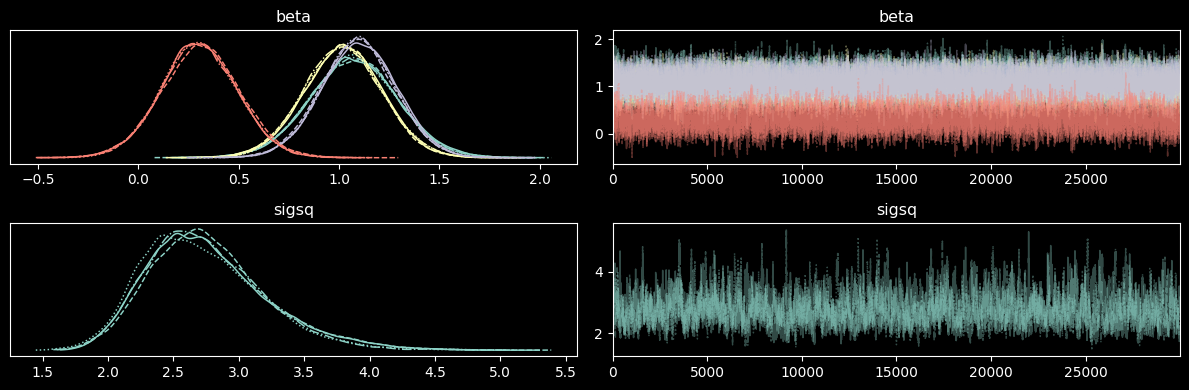

In [33]:
az.plot_trace(idata, var_names=['beta', 'sigsq'])
plt.tight_layout()

### Online inference

In [34]:
state_k, sampling_k = jax.random.split(inference_key)

fold_id, model_id = 1, 0

# parameter adaptation
init_pos_1c = find_initial_params(state_k, fold_id, model_id)
adapt = bj.window_adaptation(bj.hmc, lambda x: logjoint_density(x, fold_id, model_id),
                             num_integration_steps=num_integration_steps, progress_bar=True)
adapt_res, _ = adapt.run(jax.random.PRNGKey(123), init_pos_1c, num_steps=2_000)
print(f"Step size = {adapt_res.parameters['step_size']:.4f}, inv mm norm = {jnp.linalg.norm(adapt_res.parameters['inverse_mass_matrix']):.4f}")
print()

fm_hmc = bj.hmc(lambda x: logjoint_density(x, fold_id, model_id), **adapt_res.parameters)
state_ks = jax.random.split(state_k, num_chains)
fm_init_pos = jax.vmap(find_initial_params, in_axes=(0, None, None))(state_ks, fold_id, model_id)
fm_init_hmcstates = jax.vmap(fm_hmc.init)(fm_init_pos)
initstate = jax.vmap(init_ext_state)(fm_init_hmcstates, jax.random.split(sampling_k, num_chains))

sense_check_init_pos(fm_init_pos)

# burn-in
state, _ = inference_loop(initstate, fold_id, model_id, warmup_iter, False)
state = jax.vmap(reset_ext_state)(state)  # discard values accumulated during burn-in

logmeans = []
for i in range(total_batches):
    state, _ = inference_loop(state, fold_id, model_id, batch_size, True)
    pmean = logsumexp(log_welford_mean(state.pred_ws)) - jnp.log(num_chains)
    logmeans.append(pmean)
assert jnp.all(state.divergences == 0), print(f"WARNING: {state.divergences.sum()} divergences")
logmeans = jnp.stack(logmeans)

Running window adaptation



Step size = 0.6395, inv mm norm = 0.0793

log joint density sense checks
ljd mean m0: -206.69 m1: -207.68 diff (m0 - m1): -0.99

ljd m0 folds: -168.19, -170.83, -165.29, -170.30, -166.70
lpriord m0 folds: -14.55, -14.55, -14.55, -14.55, -14.55
lpredd m0 folds: -38.50, -35.86, -41.40, -36.39, -39.99
lpredd+ljd m0 folds: -206.69, -206.69, -206.69, -206.69, -206.69

ljd m1 folds: -168.38, -171.62, -166.49, -170.94, -167.82
lpriord m1 folds: -14.55, -14.55, -14.55, -14.55, -14.55
lpredd m1 folds: -39.30, -36.06, -41.18, -36.74, -39.85
lpredd+ljd m1 folds: -207.68, -207.68, -207.68, -207.68, -207.68


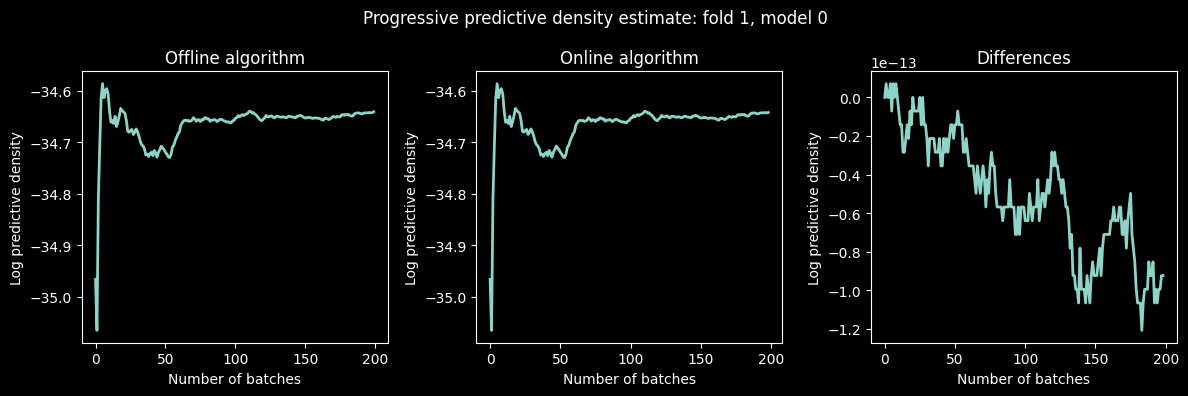

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)
offline, online, diffs = axes

offline.plot(logmeans, linewidth=2)
offline.set_title('Offline algorithm')

online.plot(lps_xpnd, linewidth=2)
online.set_title('Online algorithm')

diffs.plot(logmeans[:-1] - lps_xpnd, linewidth=2)
diffs.set_title('Differences')

for ax in axes:
    ax.set_xlabel("Number of batches")
    ax.set_ylabel("Log predictive density")

fig.suptitle(f'Progressive predictive density estimate: fold {fold_id}, model {model_id}')
fig.tight_layout()
fig.savefig('online_vs_offline.pdf', bbox_inches=0, transparent=True)

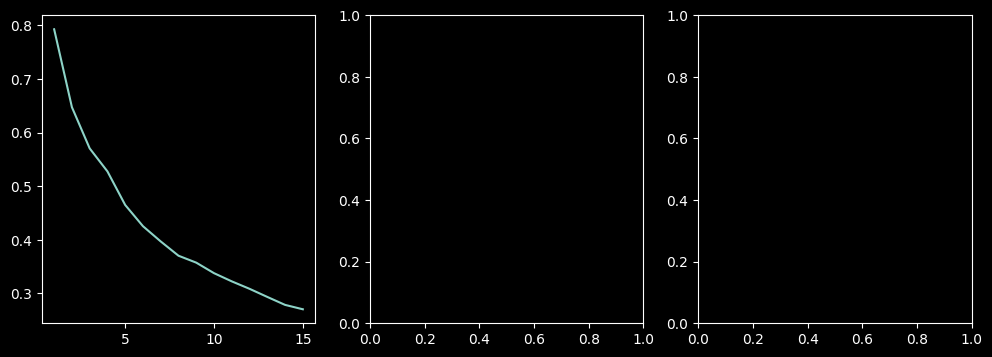

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
offline, online, diff = axes

long_means = batch_means.reshape(num_chains*total_batches)
manual_stds = jnp.array([jnp.std(long_means[:m])*jnp.sqrt(batch_size/m) for m in jnp.arange(0, long_means.shape[0], 50)])
offline.plot(manual_stds)

## Online cross-validation

In [60]:
state_k, sampling_k = jax.random.split(inference_key)

# automatic parameter adaptation - just model 0 and full data
init_pos_1c = find_initial_params(state_k, -1, 0)
adapt = bj.window_adaptation(bj.hmc, lambda x: logjoint_density(x, fold_id, model_id),
                             num_integration_steps=num_integration_steps, progress_bar=True)
adapt_res, _ = adapt.run(jax.random.PRNGKey(123), init_pos_1c, num_steps=2_000)
print(f"Step size = {adapt_res.parameters['step_size']:.4f}, "
      f"inv mm norm = {jnp.linalg.norm(adapt_res.parameters['inverse_mass_matrix']):.4f}")
print()

models, folds = jnp.arange(num_models), jnp.arange(num_folds)

def init_one_fold(fold_id, model_id):
    fm_hmc = bj.hmc(lambda x: logjoint_density(x, fold_id, model_id), **adapt_res.parameters)
    state_ks = jax.random.split(state_k, num_chains)
    fm_init_pos = jax.vmap(find_initial_params, in_axes=(0, None, None))(state_ks, fold_id, model_id)
    fm_init_hmcstates = jax.vmap(fm_hmc.init)(fm_init_pos)
    return jax.vmap(init_ext_state)(fm_init_hmcstates, jax.random.split(sampling_k, num_chains))

@jax.jit
def model_mcse(state):
    # mcse at the model level (2-vector) for log score
    mf_logvar = logsumexp(log_welford_var(state.pred_bws.batches), axis=2)
    mf_logmean = logsumexp(log_welford_mean(state.pred_ws), axis=2) - jnp.log(num_chains)
    m_var = jnp.exp(mf_logvar - 2*mf_logmean).sum(axis=1)  # model variance in levels
    m_a = state.pred_bws.batches.n.sum(axis=(1, 2))  # total batch count
    return jnp.sqrt(m_var / m_a)

@jax.jit
def cv_uncertainty_ci_logscore(state, d=0.05, ndraws=100):
    # model distribution incorporating CV uncertainty
    mf_logvar = logsumexp(log_welford_var(state.pred_bws.batches), axis=2) - jnp.log(state.pred_bws.batches.n.sum(axis=2))
    mf_logmean = logsumexp(log_welford_mean(state.pred_bws.batches), axis=2) - jnp.log(num_chains)
    simkey = jax.random.PRNGKey(42)
    simvar = jnp.exp(mf_logvar - 2*mf_logmean)
    draws = (
        jnp.expand_dims(mf_logmean, 0)
        + jnp.log(jnp.ones_like(simvar) 
                + jnp.sqrt(simvar) * jax.random.truncated_normal(simkey, -jnp.ones_like(simvar), jnp.inf, shape=(ndraws,)+simvar.shape))
    )
    # variability for individual models
    # sample stats for draw, model (taken over folds)
    dm_mean, dm_var = draws.sum(axis=2), draws.shape[2]*draws.var(axis=2, ddof=1)
    # upper normal quantile for each draw
    dm_uq = jax.scipy.stats.norm.ppf(1-d/2, loc=dm_mean, scale=jnp.sqrt(dm_var))
    dm_lq = jax.scipy.stats.norm.ppf(d/2, loc=dm_mean, scale=jnp.sqrt(dm_var))
    m_uq, m_lq = dm_uq.mean(axis=0), dm_lq.mean(axis=0)

    # variability for difference
    ddiff_mean, ddiff_var = dm_mean[:,0] - dm_mean[:,1], dm_var[:,0] + dm_var[:,1]
    ddiff_uq = jax.scipy.stats.norm.ppf(1-d/2, loc=ddiff_mean, scale=jnp.sqrt(ddiff_var))
    ddiff_lq = jax.scipy.stats.norm.ppf(d/2, loc=ddiff_mean, scale=jnp.sqrt(ddiff_var))
    diff_uq, diff_lq = ddiff_uq.mean(), ddiff_lq.mean()

    return dict(diff_uq=diff_uq, diff_lq=diff_lq, m_uq=m_uq, m_lq=m_lq)

# dimensions models x folds x chains x param dimension
init_state = jax.vmap(lambda model_id: jax.vmap(init_one_fold, in_axes=(0, None))(folds, model_id))(models)
def model_inference_loop(state, model_id, iter):
    return jax.vmap(lambda state, fold_id: inference_loop(state, fold_id, model_id, iter, True))(state, folds)
grand_inference_loop = jax.vmap(model_inference_loop, in_axes=(0, 0, None))

# burn-in
#state, _ = grand_inference_loop(init_state, models, warmup_iter)
#state = jax.vmap(jax.vmap(jax.vmap(reset_ext_state)))(state)  # discard values accumulated during burn-in

state = init_state
logmeans, mcses = [], []
diff_lq, diff_uq, m_lq, m_uq = [], [], [], []
for i in range(total_batches):
    state, _ = grand_inference_loop(state, models, batch_size)
    logmeans.append(logsumexp(log_welford_mean(state.pred_ws), axis=2) - jnp.log(num_chains))
    mcses.append(model_mcse(state))
    ci = cv_uncertainty_ci_logscore(state)
    diff_lq.append(ci['diff_lq'])
    diff_uq.append(ci['diff_uq'])
    m_lq.append(ci['m_lq'])
    m_uq.append(ci['m_uq'])
assert jnp.all(state.divergences == 0), print(f"WARNING: {state.divergences.sum()} divergences")
logmeans, mcses = jnp.stack(logmeans), jnp.stack(mcses)
diff_lq, diff_uq, m_lq, m_uq = jnp.stack(diff_lq), jnp.stack(diff_uq), jnp.stack(m_lq), jnp.stack(m_uq)
differrs = jnp.sqrt(mcses[:,0]**2 + mcses[:,1]**2)
model_means = logmeans.sum(axis=2)
delta = model_means[:, 0] - model_means[:, 1]

Running window adaptation



Step size = 0.6018, inv mm norm = 0.0788



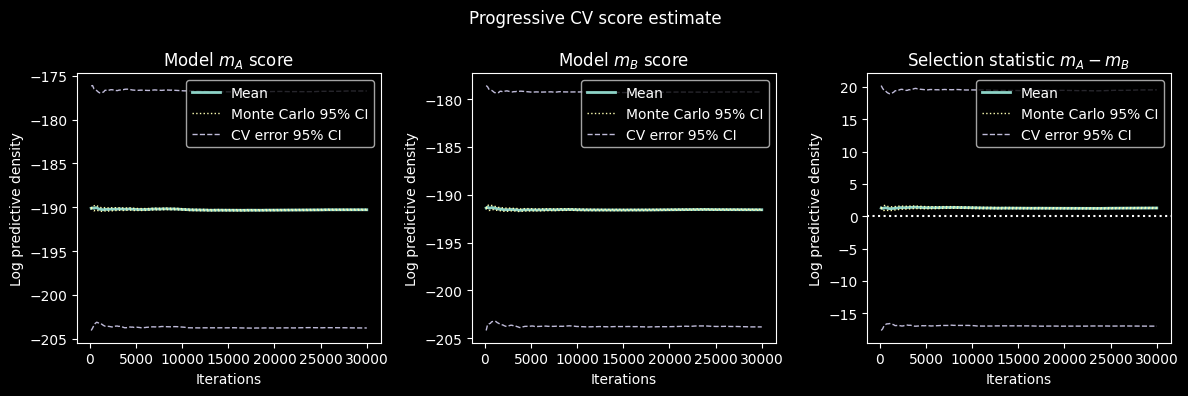

In [63]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)
mA, mB, diffs = axes
iter = jnp.arange(1, total_batches+1) * batch_size

zcrit = jax.scipy.stats.norm.ppf(0.975)

for i, ax in enumerate([mA, mB]):
    m = ax.plot(iter, model_means[:,i], linewidth=2)
    c = ax.plot(iter, model_means[:,i] + zcrit*mcses[:,i], linewidth=1, linestyle=':')
    ax.plot(iter, model_means[:,i] - zcrit*mcses[:,i], linewidth=1, linestyle=':', color=c[0].get_color())
    cv = ax.plot(iter, m_uq[:,i], linewidth=1, linestyle='--')
    ax.plot(iter, m_lq[:,i], linewidth=1, linestyle='--', color=cv[0].get_color())
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    ax.legend([m[0], c[0], cv[0]], ['Mean', 'Monte Carlo 95% CI', 'CV error 95% CI'])

mA.set_title('Model $m_A$ score')
mB.set_title('Model $m_B$ score')

m = diffs.plot(iter, delta, linewidth=2)
c = diffs.plot(iter, delta + zcrit*differrs, linewidth=1, linestyle=':')
diffs.plot(iter, delta - zcrit*differrs, linewidth=1, linestyle=':', color=c[0].get_color())
cv = diffs.plot(iter, diff_uq, linewidth=1, linestyle='--')
diffs.plot(iter, diff_lq, linewidth=1, linestyle='--', color=cv[0].get_color())
diffs.set_title('Selection statistic $m_A - m_B$')
diffs.axhline(0, linestyle=':')
diffs.legend([m[0], c[0], cv[0]], ['Mean', 'Monte Carlo 95% CI', 'CV error 95% CI'])

for ax in axes:
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Log predictive density")

fig.suptitle(f'Progressive CV score estimate')
fig.tight_layout()
fig.savefig('reg_cmp.pdf', bbox_inches=0, transparent=True)

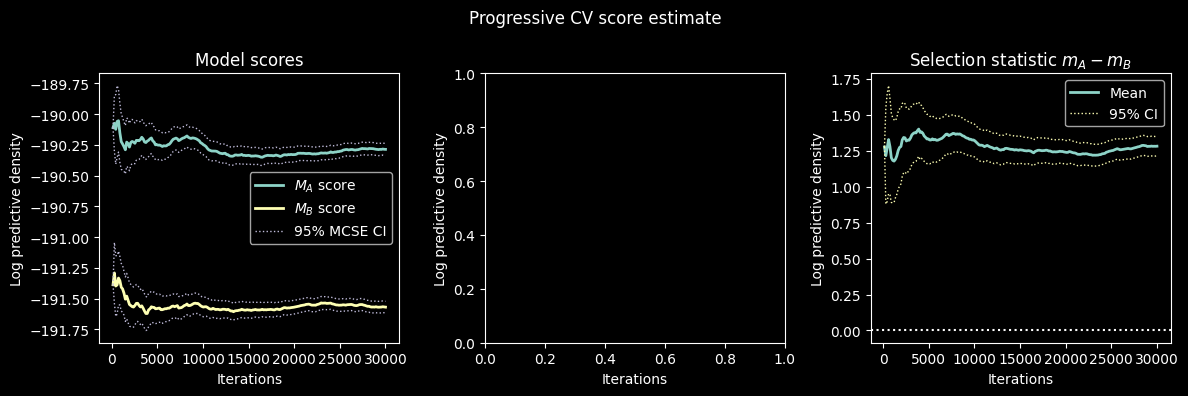

In [27]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)
totals, folds, diffs = axes
iter = jnp.arange(1, total_batches+1) * batch_size

zcrit = jax.scipy.stats.norm.ppf(0.975)

mA = totals.plot(iter, model_means[:,0], linewidth=2)
mB = totals.plot(iter, model_means[:,1], linewidth=2)
c = totals.plot(iter, model_means[:,0] + zcrit*mcses[:,0], linewidth=1, linestyle=':')
totals.plot(iter, model_means[:,0] - zcrit*mcses[:,0], linewidth=1, linestyle=':', color=c[0].get_color())
totals.plot(iter, model_means[:,1] + zcrit*mcses[:,1], linewidth=1, linestyle=':', color=c[0].get_color())
totals.plot(iter, model_means[:,1] - zcrit*mcses[:,1], linewidth=1, linestyle=':', color=c[0].get_color())
totals.get_yaxis().get_major_formatter().set_useOffset(False)
totals.legend([mA[0], mB[0], c[0]], ['$M_A$ score', '$M_B$ score', '95% MCSE CI'])
totals.set_title('Model scores')

m = diffs.plot(iter, delta, linewidth=2)
c = diffs.plot(iter, delta + zcrit*differrs, linewidth=1, linestyle=':')
diffs.plot(iter, delta - zcrit*differrs, linewidth=1, linestyle=':', color=c[0].get_color())
diffs.set_title('Selection statistic $m_A - m_B$')
diffs.axhline(0, linestyle=':')
diffs.legend([m[0], c[0]], ['Mean', '95% CI'])

for ax in axes:
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Log predictive density")

fig.suptitle(f'Progressive CV score estimate')
fig.tight_layout()
fig.savefig('reg_cmp.pdf', bbox_inches=0, transparent=True)